Обработка аудиофайлов из /home/egr/projects/nmus//data/genres...


/home/egr/projects/nmus/.venv/lib/python3.12/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/home/egr/projects/nmus/.venv/lib/python3.12/site-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3

Ошибка при обработке jazz.00054.wav: Failed to open the input "/home/egr/projects/nmus/data/genres/jazz.00054.wav" (Invalid data found when processing input).
Создано 999 сэмплов
torch.Size([1, 128, 1876])


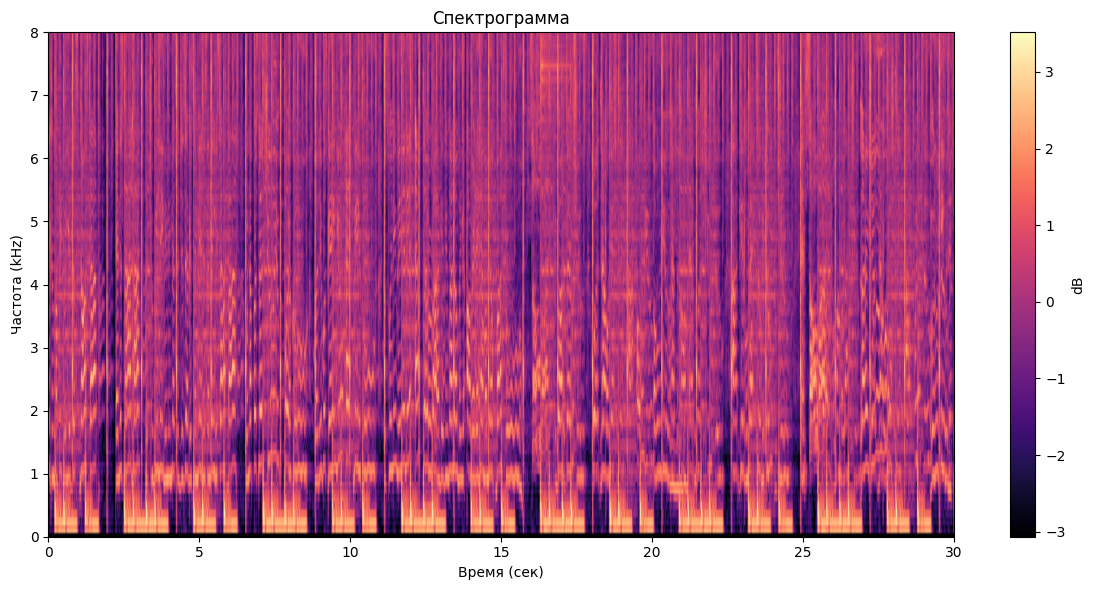

In [ ]:
import gc
import glob
import os
import pickle
import h5py
import torchaudio
import matplotlib.pyplot as plt
import torch
import numpy as np

def create_spectrogram(audio_path, sample_rate=16000, n_fft=512, hop_length=256, n_mels=128):
    
    # Загружаем аудиофайл
    waveform, original_sample_rate = torchaudio.load(audio_path)

    # Преобразуем к моно если нужно
    if waveform.shape[0] > 1:
        waveform = torch.mean(waveform, dim=0, keepdim=True)
    
    # Ресемплируем если необходимо
    if original_sample_rate != sample_rate:
        resampler = torchaudio.transforms.Resample(original_sample_rate, sample_rate)
        waveform = resampler(waveform)
    
    # Создаем mel-спектрограмму
    mel_spectrogram = torchaudio.transforms.MelSpectrogram(
        sample_rate=sample_rate,
        n_fft=n_fft,
        hop_length=hop_length,
        n_mels=n_mels
    )

    # Применяем преобразование
    spectrogram = mel_spectrogram(waveform)
    
    # Применяем логарифмическое преобразование для лучшего восприятия
    spectrogram = torchaudio.functional.amplitude_to_DB(
        spectrogram, 
        multiplier=10, 
        amin=1e-10, 
        db_multiplier=0, 
        top_db=80.0
    )
    
    # Нормализуем спектрограмму
    spectrogram = (spectrogram - spectrogram.mean()) / (spectrogram.std() + 1e-8)

    return spectrogram

def plot_spectrogram(spectrogram, sr=16000, hop_length=256, title="Спектрограмма"):
    # Конвертируем тензор в numpy для визуализации
    if isinstance(spectrogram, torch.Tensor):
        spec_np = spectrogram.squeeze().detach().cpu().numpy()
    else:
        spec_np = spectrogram.squeeze()
    
    # Создаем фигуру
    plt.figure(figsize=(12, 6))
    
    # Рассчитываем временную ось
    time_axis = np.arange(spec_np.shape[1]) * hop_length / sr
    
    # Отображаем спектрограмму
    plt.imshow(spec_np, 
               aspect='auto', 
               origin='lower', 
               extent=[0, time_axis[-1], 0, sr/2/1000],  # Преобразуем в kHz
               cmap='magma')
    
    plt.colorbar(label='dB')
    plt.xlabel('Время (сек)')
    plt.ylabel('Частота (kHz)')
    plt.title(title)
    plt.tight_layout()
    plt.show()

def create_spectrogram_dataset(audio_dir, genres_list, file_to_genre_dict, output_path, size = 1792):

    os.makedirs(output_path, exist_ok=True)
    genre_to_idx = {genre: idx for idx, genre in enumerate(genres_list)}
    
    spectrograms = []
    labels = []

    print(f"Обработка аудиофайлов из {audio_dir}...")
    
    for filename in os.listdir(audio_dir):
        if filename.endswith('.wav') and filename in file_to_genre_dict:
            audio_path = os.path.join(audio_dir, filename)
            genre = file_to_genre_dict[filename]
            
            try:
                spectrogram = create_spectrogram(audio_path)[:,:,:size]
                
                if (spectrogram.shape == (1, 128, size)):
                    spectrograms.append(spectrogram)
                    labels.append(genre_to_idx[genre])
                
                # Нарезаем сегменты
                # total_frames = spectrogram.shape[2]
                # max_start = total_frames - size

                # if max_start > 0:
                #     for i in range(int(total_frames / size)):
                #         start_pos = size * i
                #         segment = spectrogram[:, :, start_pos:start_pos+size]
                #         if segment.shape == (1, n_mels, size):
                #             spectrograms.append(segment)
                #             labels.append(genre_to_idx[genre])
                
            except Exception as e:
                print(f"Ошибка при обработке {filename}: {e}")

    # Сохраняем датасет
    dataset_dict = {
        'spectrograms': np.array(spectrograms, dtype=np.float32),
        'labels': np.array(labels, dtype=np.int64),
        'genre_to_idx': genre_to_idx,
        'idx_to_genre': {idx: genre for genre, idx in genre_to_idx.items()},
    }
    
    with open(os.path.join(output_path, 'genres_dataset.pkl'), 'wb') as f:
        pickle.dump(dataset_dict, f)
    
    print(f"Создано {len(spectrograms)} сэмплов")
    return dataset_dict

# словарь название-файла - лейбл
genres = ['blues','classical','country','disco','hiphop','jazz','metal', 'pop', 'reggae', 'rock']
dict_genres = {}
for genre in genres:
    for i in range(100):
        key = genre + "." + str(i).zfill(5) + ".wav"
        dict_genres[key] = genre

create_spectrogram_dataset("/home/egr/projects/nmus//data/genres", genres, dict_genres, "/home/egr/projects/nmus//data/datasets")
spec = create_spectrogram("/home/egr/projects/nmus/data/genres/pop.00055.wav")
print(spec.shape)
plot_spectrogram(spec.numpy())